In [1]:
import pandas as pd
from evaluations.evaluation_data.evaluation_data import EvaluationData
from tampering.tampering import Tampering
from timf.timf import TIMF
from data_service.data_service import DataService
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score



evaluation_data = EvaluationData()
tampering = Tampering()    
data_service = DataService()
timf = TIMF(data_service)
data = evaluation_data.get_data()


def _haversine_km(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2.0) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    return 6371.0 * c

from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

def compute_metrics_from_labels(y_true_labels, y_pred_labels):
    """
    Inputs are arrays/Series with values 'T' or 'C'
    """
    y_true = (pd.Series(y_true_labels) == 'T').astype(int)
    y_pred = (pd.Series(y_pred_labels) == 'T').astype(int)

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)

    try:
        auc = roc_auc_score(y_true, y_pred)
    except ValueError:
        auc = None

    return accuracy, precision, recall, auc

def _to_bin_labels(y):
    """Map labels to 0/1 where 'T' is positive (1), everything else is 0."""
    return np.array([1 if str(v) == 'T' else 0 for v in y], dtype=int)

def safe_auc(y_true_labels, y_scores):
    """
    Robust AUC:
    - returns np.nan if empty or only one class present
    - expects y_true_labels like ['T','C',...] and y_scores numeric
    """
    if y_true_labels is None or y_scores is None:
        return np.nan
    if len(y_true_labels) == 0 or len(y_scores) == 0:
        return np.nan

    y_true_bin = _to_bin_labels(y_true_labels)
    y_scores = np.asarray(y_scores, dtype=float)

    # lengths must match
    if y_true_bin.shape[0] != y_scores.shape[0]:
        raise ValueError(f"AUC length mismatch: y_true={len(y_true_bin)} vs y_score={len(y_scores)}")

    # AUC needs both classes
    if np.unique(y_true_bin).size < 2:
        return np.nan

    return float(roc_auc_score(y_true_bin, y_scores))

def compute_metrics_from_labels(y_true_labels, y_pred_labels):
    """
    Your existing label-based metrics (Accuracy / Precision / Recall).
    Assumes positive class is 'T'.
    """
    y_true_bin = _to_bin_labels(y_true_labels)
    y_pred_bin = _to_bin_labels(y_pred_labels)

    acc = float(accuracy_score(y_true_bin, y_pred_bin))
    prec = float(precision_score(y_true_bin, y_pred_bin, zero_division=0))
    rec = float(recall_score(y_true_bin, y_pred_bin, zero_division=0))
    return acc, prec, rec


No existing evaluation data found. It will be created.
Preparing evaluation data environment...
Loading Airbnb data for evaluation...
  Loading from data_source/Sydney...
  Loading from data_source/Melbourne...


/Users/thilina/Data_space/phd_experiments/toit_experiments/toit_revamp/evaluations/evaluation_data/evaluation_data.py:161: DtypeWarning: Columns (59,60) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f'{location}/listings{i}.csv')


  Loading from data_source/MidNorthCoast...
  Loading from data_source/NothernRivers...
Number of samples : 42547
Number of uniques providers : 1651
Number of microcells:81
Data loading completed.


In [2]:

tampering_percentages = list(range(50, 60, 40))

tampering_types = ["N"]  # Naive, Knowledgeable, Sophisticated

availability = 1
repliocation_mic = 5
# tampering_types = ["N"]
        
results = []

results_metrics = []

for tampering_type in tampering_types:
    for tampering_percentage in tampering_percentages:

        print(f"Experiment: Tampering Type={tampering_type}, Percentage={tampering_percentage}%")

        for assessing_mic in data['gen_microcell'].unique():
            # print(assessing_mic)
            full_df = data.copy()
            df_microcell = data[data['gen_microcell'] == assessing_mic].copy()
            remaining_df = data[data['gen_microcell'] != assessing_mic].copy()

            # -------- Remote tampering (BMA) --------
            bma_tampered_df = tampering.bma_tampering(
                remaining_df.reset_index(drop=True),
                tampering_percentage,
                tampering_type
            )
            remote_data = bma_tampered_df.copy()

            # remote_data = data[data['gen_microcell'] != assessing_mic].reset_index(drop=True)

            # -------- Replication logic --------
            microcell_coords = full_df.groupby('gen_microcell')[['latitude', 'longitude']].first().reset_index()
            current_coords = microcell_coords[microcell_coords['gen_microcell'] == assessing_mic]

            if not current_coords.empty:
                lat1 = current_coords['latitude'].values[0]
                lon1 = current_coords['longitude'].values[0]

                df_microcell_part = df_microcell.copy()
                df_microcell_part.loc[:, 'currect_microcell'] = assessing_mic

                replicated_parts = [df_microcell_part]

                for provider_id in df_microcell['providerid'].unique():

                    provider_remote = remote_data[remote_data['providerid'] == provider_id]
                    candidate_microcells = []

                    for _, row in microcell_coords.iterrows():
                        if row['gen_microcell'] == assessing_mic:
                            continue
                        if (provider_remote['gen_microcell'] == row['gen_microcell']).any():
                            dist = _haversine_km(lat1, lon1, row['latitude'], row['longitude'])
                            candidate_microcells.append((row['gen_microcell'], dist))

                    candidate_microcells.sort(key=lambda x: x[1])
                    nearby_microcells = [m for m, _ in candidate_microcells[:repliocation_mic]]

                    if nearby_microcells:
                        df_remote = remote_data[
                            (remote_data['providerid'] == provider_id) &
                            (remote_data['gen_microcell'].isin(nearby_microcells))
                        ].drop_duplicates(subset='serviceid')

                        if not df_remote.empty:
                            df_remote['origin'] = 'R'
                            df_remote['currect_microcell'] = assessing_mic
                            replicated_parts.append(df_remote)

                df_microcell_replicated = pd.concat(replicated_parts, ignore_index=True)
            else:
                df_microcell_replicated = df_microcell.copy()

            # -------- Local tampering (SPA) --------
            spa_tampered_df = tampering.spa_tampering(
                df_microcell_replicated,
                type=tampering_type
            )

            # -------- Set TIMF data --------
            data_service.set_local_data(spa_tampered_df.copy())

            # --- Full remote pool (all other microcells) ---
            # remote_data_set = full_df[full_df['gen_microcell'] != assessing_mic].copy()

            # remote_data_set = data[data['gen_microcell'] != assessing_mic].copy()

            remote_data_set = bma_tampered_df.copy()


            count_df = (
                spa_tampered_df
                .groupby(['currect_microcell', 'origin'])
                .size()
                .unstack(fill_value=0)
                .reset_index()
            )

            # ensure both columns exist
            if 'G' not in count_df.columns:
                count_df['G'] = 0
            if 'R' not in count_df.columns:
                count_df['R'] = 0

            origin_count = int(count_df.loc[0, 'G'])  # generated/origin
            replicated_count = int(count_df.loc[0, 'R'])  # replicated/received

            results_metrics.append({
                "tampering_type": tampering_type,
                "tampering_percentage": tampering_percentage,
                "assessing_mic": assessing_mic,
                "origin_G": origin_count,
                "replicated_R": replicated_count,
                "total": origin_count + replicated_count
            })

            

            





Experiment: Tampering Type=N, Percentage=50%


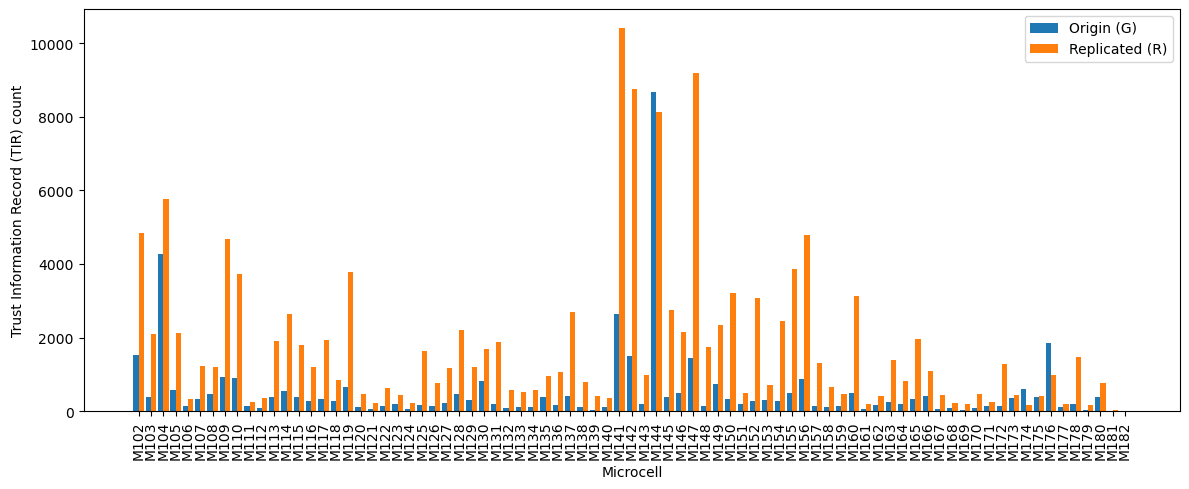

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

dfm = pd.DataFrame(results_metrics)

# one plot per experiment setting
for (tt, tp), sub in dfm.groupby(["tampering_type", "tampering_percentage"]):
    sub = sub.sort_values("assessing_mic").reset_index(drop=True)

    x = np.arange(len(sub))
    width = 0.42

    plt.figure(figsize=(12, 5))
    plt.bar(x - width/2, sub["origin_G"].to_numpy(), width, label="Origin (G)")
    plt.bar(x + width/2, sub["replicated_R"].to_numpy(), width, label="Replicated (R)")

    plt.xticks(x, sub["assessing_mic"].astype(str).tolist(), rotation=90)
    plt.ylabel("Trust Information Record (TIR) count")
    plt.xlabel("Microcell")
    # plt.title(f"Origin vs Replicated counts per microcell | Type={tt}, Tampering={tp}%")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [ ]:
import pandas as pd

df_table = pd.DataFrame(results_metrics)

# reorder columns nicely
df_table = df_table[
    [
        "tampering_type",
        "tampering_percentage",
        "assessing_mic",
        "origin_G",
        "replicated_R",
        "total",
    ]
]

df_table


In [ ]:
import pandas as pd

df_table = pd.DataFrame(results_metrics)

# reorder columns nicely
df_table = df_table[
    [
        "tampering_type",
        "tampering_percentage",
        "assessing_mic",
        "origin_G",
        "replicated_R",
        "total",
    ]
]

df_table

In [ ]:
import pandas as pd

df = pd.DataFrame(results_metrics)

metrics_table = df[
    [
        "tampering_type",
        "tampering_percentage",
        "microcell",
        "method",
        "accuracy",
        "precision",
        "recall",
        "AUC_all",
        "AUC_R",
        "AUC_G",
    ]
].copy()

metrics_table = metrics_table.sort_values(
    by=["tampering_type", "tampering_percentage", "method"]
).reset_index(drop=True)

metrics_table


In [ ]:
avg_metrics = (
    metrics_table
    .groupby(
        ["tampering_type", "tampering_percentage", "method"],
        as_index=False
    )
    .mean(numeric_only=True)
)

avg_metrics


In [ ]:
results_metrics

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from itertools import cycle

# Pretty names for methods (legend)
method_labels = {
    
    "TDA": "TDA (our approch)",
    "IsolationForest": "IFUM",
    "LOF": "LOFM",
    "OCSVM": "OCSVM",
    "TIMF": "TIMF"
}

# Pretty names for tampering types (title)
tampering_labels = {
    "N": "Naïve Attack",
    "K": "Knowledge-based Attack",
    "S": "Sophisticated Attack"
}

# Pretty names for metrics (subplot titles / y-axis)
metric_labels = {
    "accuracy": "(A) Accuracy",
    "precision": "(B) Precision",
    "recall": "(R) Recall"
}



# Prepare the DataFrame
metrics_df = pd.DataFrame(results_metrics).dropna(
    subset=['accuracy', 'precision', 'recall']
)

# Compute mean metrics
summary = (
    metrics_df
    .groupby(['tampering_type', 'tampering_percentage', 'method'], as_index=False)
    [['accuracy', 'precision', 'recall']]
    .mean()
)

tampering_types = ["N", "K", "S"]
metric_names = ['accuracy', 'precision', 'recall']

# Marker and line-style cycles (color-blind friendly)
markers = cycle(['o', 's', '^', 'D',])
linestyles = cycle(['-', '--', '-.', ':'])

method_colors = {
    "TDA": "tab:green",          # proposed method
    "IsolationForest": "tab:orange",
    "LOF": "tab:blue",
    "OCSVM": "tab:red",
    "TIMF": "tab:purple"
}


# Loop over each tampering type
for t_type in tampering_types:
    subset_type = summary[summary['tampering_type'] == t_type]
    methods = subset_type['method'].unique()

    # Assign a unique (marker, linestyle) per method
    style_map = {
        method: (next(markers), next(linestyles))
        for method in methods
    }

    fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=True)
    # fig.suptitle(f'Metrics for Tampering Type {t_type}', fontsize=16)

    for idx, metric in enumerate(metric_names):
        ax = axes[idx]

        for method in methods:
            subset_method = subset_type[subset_type['method'] == method]
            marker, linestyle = style_map[method]

            ax.plot(
                subset_method['tampering_percentage'],
                subset_method[metric],
                marker=marker,
                linestyle=linestyle,
                linewidth=2,
                markersize=6,
                label=method_labels.get(method, method),
                 color=method_colors.get(method, None)  # <-- force blue for TDA
            )

        ax.set_title(metric.capitalize())
        ax.set_xlabel('Tampering Percentage')
        ax.set_ylabel(metric.capitalize())
        ax.set_ylim(0, 1)
        ax.grid(True, alpha=0.3)

    axes[0].legend(title='Method', frameon=True)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.DataFrame(results_metrics)

# focus on TDA only
df_tda = df[df['method'] == 'TDA']

# average across microcells
agg = df_tda.groupby('tampering_percentage').agg({
    'AUC_R': 'mean',
    'AUC_G': 'mean',
    'AUC_all': 'mean'
}).reset_index()

plt.figure(figsize=(6, 4))
plt.plot(agg['tampering_percentage'], agg['AUC_R'], marker='o', label='TDA (AUC_R)')
plt.plot(agg['tampering_percentage'], agg['AUC_G'], marker='s', label='TDA (AUC_G)')

# optional
if 'AUC_all' in agg:
    plt.plot(agg['tampering_percentage'], agg['AUC_all'], marker='^', linestyle='--', label='TDA (AUC_all)')

plt.xlabel('Tampering Percentage (%)')
plt.ylabel('AUC')
plt.ylim(0, 1.0)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd

df = pd.DataFrame(results_metrics)

avg_df = (
    df
    .groupby(['method', 'tampering_type','tampering_percentage'])[['accuracy', 'precision', 'recall']]
    .mean()
    .reset_index()
)

print(avg_df)


In [ ]:
tampering_percentages = list(range(10, 100, 10))

# tampering_types = ["N", "K", "S"]  # Naive, Knowledgeable, Sophisticated
tampering_types = ["N"]
        
results = []

results_metrics = []

for tampering_type in tampering_types:
    for tampering_percentage in tampering_percentages:

        print(f"Experiment: Tampering Type={tampering_type}, Percentage={tampering_percentage}%")

        for assessing_mic in data['gen_microcell'].unique():
            full_df = data.copy()
            df_microcell = data[data['gen_microcell'] == assessing_mic].copy()
            remaining_df = data[data['gen_microcell'] != assessing_mic].copy()

            # -------- Remote tampering (BMA) --------
            bma_tampered_df = tampering.bma_tampering(
                remaining_df.reset_index(drop=True),
                tampering_percentage,
                tampering_type
            )
            remote_data = bma_tampered_df

            # remote_data = data[data['gen_microcell'] != assessing_mic].reset_index(drop=True)

            # -------- Replication logic --------
            microcell_coords = full_df.groupby('gen_microcell')[['latitude', 'longitude']].first().reset_index()
            current_coords = microcell_coords[microcell_coords['gen_microcell'] == assessing_mic]

            if not current_coords.empty:
                lat1 = current_coords['latitude'].values[0]
                lon1 = current_coords['longitude'].values[0]

                df_microcell_part = df_microcell.copy()
                df_microcell_part.loc[:, 'currect_microcell'] = assessing_mic

                replicated_parts = [df_microcell_part]

                for provider_id in df_microcell['providerid'].unique():

                    provider_remote = remote_data[remote_data['providerid'] == provider_id]
                    candidate_microcells = []

                    for _, row in microcell_coords.iterrows():
                        if row['gen_microcell'] == assessing_mic:
                            continue
                        if (provider_remote['gen_microcell'] == row['gen_microcell']).any():
                            dist = _haversine_km(lat1, lon1, row['latitude'], row['longitude'])
                            candidate_microcells.append((row['gen_microcell'], dist))

                    candidate_microcells.sort(key=lambda x: x[1])
                    nearby_microcells = [m for m, _ in candidate_microcells[:38]]

                    if nearby_microcells:
                        df_remote = remote_data[
                            (remote_data['providerid'] == provider_id) &
                            (remote_data['gen_microcell'].isin(nearby_microcells))
                        ].drop_duplicates(subset='serviceid')

                        if not df_remote.empty:
                            df_remote['origin'] = 'R'
                            df_remote['currect_microcell'] = assessing_mic
                            replicated_parts.append(df_remote)

                df_microcell_replicated = pd.concat(replicated_parts, ignore_index=True)
            else:
                df_microcell_replicated = df_microcell.copy()

            # -------- Local tampering (SPA) --------
            spa_tampered_df = tampering.spa_tampering(
                df_microcell_replicated,
                type=tampering_type
            )

            # -------- Set TIMF data --------
            data_service.set_local_data(spa_tampered_df.copy())

            # --- Full remote pool (all other microcells) ---
            remote_data_set = full_df[full_df['gen_microcell'] != assessing_mic].copy()

            
    
            rng = np.random.default_rng(42)  # fixed seed for reproducibility
            uni_mic = remote_data_set['gen_microcell'].unique()

            selected_mics = rng.choice(
                uni_mic,
                size=max(1, int(len(uni_mic) * 1)),
                replace=False
            )

            # --- Keep only records from selected microcells ---
            remote_available = remote_data_set[remote_data_set['gen_microcell'].isin(selected_mics)].copy()

            # --- Set remote data (partial availability) ---
            data_service.set_remote_data(remote_available)

            # print(spa_tampered_df.shape[0],bma_tampered_df.shape[0],df_microcell.shape[0]+bma_tampered_df.shape[0])

            if assessing_mic == 'M110':
                print(tampering_percentage,remote_data['true_label'].value_counts())






In [ ]:

tampering_percentages = list(range(50, 60, 10))

tampering_types = ["N", "K", "S"]  # Naive, Knowledgeable, Sophisticated
# tampering_types = ["N"]
        
results = []

results_metrics = []

for tampering_type in tampering_types:
    for tampering_percentage in tampering_percentages:

        print(f"Experiment: Tampering Type={tampering_type}, Percentage={tampering_percentage}%")

        for assessing_mic in data['gen_microcell'].unique():
            full_df = data.copy()
            df_microcell = data[data['gen_microcell'] == assessing_mic].copy()
            remaining_df = data[data['gen_microcell'] != assessing_mic].copy()

            # -------- Remote tampering (BMA) --------
            bma_tampered_df = tampering.bma_tampering(
                remaining_df.reset_index(drop=True),
                tampering_percentage,
                tampering_type
            )
            remote_data = bma_tampered_df.copy()

            # remote_data = data[data['gen_microcell'] != assessing_mic].reset_index(drop=True)

            # -------- Replication logic --------
            microcell_coords = full_df.groupby('gen_microcell')[['latitude', 'longitude']].first().reset_index()
            current_coords = microcell_coords[microcell_coords['gen_microcell'] == assessing_mic]

            if not current_coords.empty:
                lat1 = current_coords['latitude'].values[0]
                lon1 = current_coords['longitude'].values[0]

                df_microcell_part = df_microcell.copy()
                df_microcell_part.loc[:, 'currect_microcell'] = assessing_mic

                replicated_parts = [df_microcell_part]

                for provider_id in df_microcell['providerid'].unique():

                    provider_remote = remote_data[remote_data['providerid'] == provider_id]
                    candidate_microcells = []

                    for _, row in microcell_coords.iterrows():
                        if row['gen_microcell'] == assessing_mic:
                            continue
                        if (provider_remote['gen_microcell'] == row['gen_microcell']).any():
                            dist = _haversine_km(lat1, lon1, row['latitude'], row['longitude'])
                            candidate_microcells.append((row['gen_microcell'], dist))

                    candidate_microcells.sort(key=lambda x: x[1])
                    nearby_microcells = [m for m, _ in candidate_microcells[:38]]

                    if nearby_microcells:
                        df_remote = remote_data[
                            (remote_data['providerid'] == provider_id) &
                            (remote_data['gen_microcell'].isin(nearby_microcells))
                        ].drop_duplicates(subset='serviceid')

                        if not df_remote.empty:
                            df_remote['origin'] = 'R'
                            df_remote['currect_microcell'] = assessing_mic
                            replicated_parts.append(df_remote)

                df_microcell_replicated = pd.concat(replicated_parts, ignore_index=True)
            else:
                df_microcell_replicated = df_microcell.copy()

            # -------- Local tampering (SPA) --------
            spa_tampered_df = tampering.spa_tampering(
                df_microcell_replicated,
                type=tampering_type
            )

            # -------- Set TIMF data --------
            data_service.set_local_data(spa_tampered_df.copy())

            # --- Full remote pool (all other microcells) ---
            # remote_data_set = full_df[full_df['gen_microcell'] != assessing_mic].copy()

            # remote_data_set = data[data['gen_microcell'] != assessing_mic].copy()

            remote_data_set = bma_tampered_df.copy()



            # --- Select 80% of microcells (availability by microcell) ---
            rng = np.random.default_rng(42)  # fixed seed for reproducibility
            uni_mic = remote_data_set['gen_microcell'].unique()

            selected_mics = rng.choice(
                uni_mic,
                size=max(1, int(len(uni_mic) * 0.8)),
                replace=False
            )

            # --- Keep only records from selected microcells ---
            remote_available = remote_data_set[remote_data_set['gen_microcell'].isin(selected_mics)].copy()

            # --- Set remote data (partial availability) ---
            data_service.set_remote_data(remote_available)

            # =====================================================
            # Collect metrics per microcell across all providers
            # =====================================================
            tda_true, tda_pred = [], []
            tda_time_entries = []

            # ---- NEW: for AUC we need continuous scores
            # Overall (optional)
            tda_true_all, tda_score_all = [], []
            # Part 1 (R)
            tda_true_R, tda_score_R = [], []
            # Part 2 (G)
            tda_true_G, tda_score_G = [], []

            baseline_true = {'IsolationForest': [], 'LOF': [], 'OCSVM': []}
            baseline_pred = {'IsolationForest': [], 'LOF': [], 'OCSVM': []}
            baseline_time_entries = {'IsolationForest': [], 'LOF': [], 'OCSVM': []}

            # If your baselines also expose scores later, you can add baseline_score lists too.

            for provider in df_microcell['providerid'].unique():

                # ---------- TDA ----------
                # IMPORTANT: df_tda must contain: origin, true_label, label, and score_R/score_G/score
                _, df_tda, time_df = timf.trust_assessment(provider, assessing_mic)

                if df_tda is not None and not df_tda.empty:
                    # label-based metrics (existing)
                    tda_true.extend(df_tda['true_label'].tolist())
                    tda_pred.extend(df_tda['label'].tolist())

                    # ---- AUC: collect continuous scores if present
                    # Overall AUC (if you want it)
                    if 'score' in df_tda.columns:
                        m = df_tda['score'].notna()
                        tda_true_all.extend(df_tda.loc[m, 'true_label'].tolist())
                        tda_score_all.extend(df_tda.loc[m, 'score'].astype(float).tolist())

                    # Part 1 AUC (received)
                    if 'score_R' in df_tda.columns and 'origin' in df_tda.columns:
                        m = (df_tda['origin'] == 'R') & (df_tda['score_R'].notna())
                        tda_true_R.extend(df_tda.loc[m, 'true_label'].tolist())
                        tda_score_R.extend(df_tda.loc[m, 'score_R'].astype(float).tolist())

                    # Part 2 AUC (generated)
                    if 'score_G' in df_tda.columns and 'origin' in df_tda.columns:
                        m = (df_tda['origin'] == 'G') & (df_tda['score_G'].notna())
                        tda_true_G.extend(df_tda.loc[m, 'true_label'].tolist())
                        tda_score_G.extend(df_tda.loc[m, 'score_G'].astype(float).tolist())

                if isinstance(time_df, dict):
                    tda_time_entries.append({
                        'records': time_df.get('records', np.nan),
                        'time_sec': time_df.get('time', np.nan)
                    })

                # ---------- Baseline: IsolationForest ----------
                df_if, t_if = timf.trust_assessment_baseline_ifum(provider, assessing_mic)

                if df_if is not None and not df_if.empty:
                    baseline_true['IsolationForest'].extend(df_if['true_label'].tolist())
                    baseline_pred['IsolationForest'].extend(df_if['label'].tolist())

                if isinstance(t_if, dict):
                    baseline_time_entries['IsolationForest'].append({
                        'records': t_if.get('records', np.nan),
                        'time_sec': t_if.get('time', np.nan)
                    })

                # ---------- Baseline: LOF ----------
                df_lof, t_lof = timf.trust_assessment_baseline_lof(provider, assessing_mic)

                if df_lof is not None and not df_lof.empty:
                    baseline_true['LOF'].extend(df_lof['true_label'].tolist())
                    baseline_pred['LOF'].extend(df_lof['label'].tolist())

                if isinstance(t_lof, dict):
                    baseline_time_entries['LOF'].append({
                        'records': t_lof.get('records', np.nan),
                        'time_sec': t_lof.get('time', np.nan)
                    })

                # ---------- Baseline: OCSVM ----------
                df_oc, t_oc = timf.trust_assessment_baseline_ocsvm(provider, assessing_mic)

                if df_oc is not None and not df_oc.empty:
                    baseline_true['OCSVM'].extend(df_oc['true_label'].tolist())
                    baseline_pred['OCSVM'].extend(df_oc['label'].tolist())

                if isinstance(t_oc, dict):
                    baseline_time_entries['OCSVM'].append({
                        'records': t_oc.get('records', np.nan),
                        'time_sec': t_oc.get('time', np.nan)
                    })

            # =====================================================
            # Save rows (TDA + baselines)
            # =====================================================
            rows_to_add = []

            # ---- TDA row
            if len(tda_true) > 0:
                acc, prec, rec = compute_metrics_from_labels(tda_true, tda_pred)

                # ---- NEW: AUCs from scores
                auc_all = safe_auc(tda_true_all, tda_score_all)  # optional
                auc_R = safe_auc(tda_true_R, tda_score_R)
                auc_G = safe_auc(tda_true_G, tda_score_G)

                rows_to_add.append({
                    'tampering_type': tampering_type,
                    'tampering_percentage': tampering_percentage,
                    'microcell': assessing_mic,
                    'provider_id': 'ALL',
                    'method': 'TDA',
                    'accuracy': acc,
                    'precision': prec,
                    'recall': rec,
                    'AUC_all': auc_all,
                    'AUC_R': auc_R,
                    'AUC_G': auc_G,
                    'time_records': tda_time_entries
                })

            # ---- Baseline rows (label-based AUC not possible unless you return scores)
            # If your baseline wrappers later return a continuous score column (recommended),
            # compute AUC the same way as above using safe_auc(y_true, y_score).
            for method_name in ['IsolationForest', 'LOF', 'OCSVM']:
                if len(baseline_true[method_name]) == 0:
                    continue

                acc, prec, rec = compute_metrics_from_labels(
                    baseline_true[method_name],
                    baseline_pred[method_name]
                )

                rows_to_add.append({
                    'tampering_type': tampering_type,
                    'tampering_percentage': tampering_percentage,
                    'microcell': assessing_mic,
                    'provider_id': 'ALL',
                    'method': method_name,
                    'accuracy': acc,
                    'precision': prec,
                    'recall': rec,
                    # AUC requires continuous scores; keep as NaN unless you return scores
                    'AUC_all': np.nan,
                    'AUC_R': np.nan,
                    'AUC_G': np.nan,
                    'time_records': baseline_time_entries[method_name]
                })

            results_metrics.extend(rows_to_add)


In [ ]:
results_metrics

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from itertools import cycle

# Pretty names for methods (legend)
method_labels = {
    
    "TDA": "TDA (our approch)",
    "IsolationForest": "IFUM",
    "LOF": "LOFM",
    "OCSVM": "OCSVM",
    "TIMF": "TIMF"
}

# Pretty names for tampering types (title)
tampering_labels = {
    "N": "Naïve Attack",
    "K": "Knowledge-based Attack",
    "S": "Sophisticated Attack"
}

# Pretty names for metrics (subplot titles / y-axis)
metric_labels = {
    "accuracy": "(A) Accuracy",
    "precision": "(B) Precision",
    "recall": "(R) Recall"
}



# Prepare the DataFrame
metrics_df = pd.DataFrame(results_metrics).dropna(
    subset=['accuracy', 'precision', 'recall']
)

# Compute mean metrics
summary = (
    metrics_df
    .groupby(['tampering_type', 'tampering_percentage', 'method'], as_index=False)
    [['accuracy', 'precision', 'recall']]
    .mean()
)

tampering_types = ["N", "K", "S"]
metric_names = ['accuracy', 'precision', 'recall']

# Marker and line-style cycles (color-blind friendly)
markers = cycle(['o', 's', '^', 'D',])
linestyles = cycle(['-', '--', '-.', ':'])

method_colors = {
    "TDA": "tab:green",          # proposed method
    "IsolationForest": "tab:orange",
    "LOF": "tab:blue",
    "OCSVM": "tab:red",
    "TIMF": "tab:purple"
}


# Loop over each tampering type
for t_type in tampering_types:
    subset_type = summary[summary['tampering_type'] == t_type]
    methods = subset_type['method'].unique()

    # Assign a unique (marker, linestyle) per method
    style_map = {
        method: (next(markers), next(linestyles))
        for method in methods
    }

    fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=True)
    # fig.suptitle(f'Metrics for Tampering Type {t_type}', fontsize=16)

    for idx, metric in enumerate(metric_names):
        ax = axes[idx]

        for method in methods:
            subset_method = subset_type[subset_type['method'] == method]
            marker, linestyle = style_map[method]

            ax.plot(
                subset_method['tampering_percentage'],
                subset_method[metric],
                marker=marker,
                linestyle=linestyle,
                linewidth=2,
                markersize=6,
                label=method_labels.get(method, method),
                 color=method_colors.get(method, None)  # <-- force blue for TDA
            )

        ax.set_title(metric.capitalize())
        ax.set_xlabel('Tampering Percentage')
        ax.set_ylabel(metric.capitalize())
        ax.set_ylim(0, 1)
        ax.grid(True, alpha=0.3)

    axes[0].legend(title='Method', frameon=True)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from itertools import cycle

# Prepare the DataFrame
metrics_df = pd.DataFrame(results_metrics).dropna(
    subset=['accuracy', 'precision', 'recall']
)

# Compute mean metrics
summary = (
    metrics_df
    .groupby(['tampering_type', 'tampering_percentage', 'method'], as_index=False)
    [['accuracy', 'precision', 'recall']]
    .mean()
)

tampering_types = ["N", "K", "S"]
metric_names = ['accuracy', 'precision', 'recall']

# Marker and line-style cycles (color-blind friendly)
markers = cycle(['o', 's', '^', 'D', 'X', 'P', 'v'])
linestyles = cycle(['-', '--', '-.', ':'])

# Loop over each tampering type
for t_type in tampering_types:
    subset_type = summary[summary['tampering_type'] == t_type]
    methods = subset_type['method'].unique()

    # Assign a unique (marker, linestyle) per method
    style_map = {
        method: (next(markers), next(linestyles))
        for method in methods
    }

    fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=True)
    # fig.suptitle(f'Metrics for Tampering Type {t_type}', fontsize=16)

    for idx, metric in enumerate(metric_names):
        ax = axes[idx]

        for method in methods:
            subset_method = subset_type[subset_type['method'] == method]
            marker, linestyle = style_map[method]

            ax.plot(
                subset_method['tampering_percentage'],
                subset_method[metric],
                marker=marker,
                linestyle=linestyle,
                linewidth=2,
                markersize=6,
                label=method
            )

        ax.set_title(metric.capitalize())
        ax.set_xlabel('Tampering Percentage')
        ax.set_ylabel(metric.capitalize())
        ax.set_ylim(0, 1)
        ax.grid(True, alpha=0.3)

    axes[0].legend(title='Method', frameon=True)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


In [ ]:
agg

In [ ]:
plt.figure(figsize=(6, 4))

df_box = df_tda[['tampering_percentage', 'AUC_R', 'AUC_G']].melt(
    id_vars='tampering_percentage',
    value_vars=['AUC_R', 'AUC_G'],
    var_name='Stage',
    value_name='AUC'
)

df_box.dropna(inplace=True)

for stage, marker in zip(['AUC_R', 'AUC_G'], ['o', 's']):
    subset = df_box[df_box['Stage'] == stage]
    plt.scatter(subset['tampering_percentage'], subset['AUC'], alpha=0.4, label=stage)

plt.xlabel('Tampering Percentage (%)')
plt.ylabel('AUC')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
